In [2]:
import psycopg2
import pandas as pd
import tqdm
from collections import Counter
import pylab as pl
import random
import xgboost
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.calibration import calibration_curve
from scipy.stats import mannwhitneyu


pd.set_option('display.max_columns', None)

In [3]:
# create a database connection
sqluser = 'wboag'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to the database
con = psycopg2.connect(dbname=dbname, user=sqluser, host="/var/run/postgresql")

# Cohort Creation

In [4]:
# TODO: exclude patients who die in-hospital
cohort_query = '''
WITH T AS (
        SELECT subject_id, MAX(admittime) AS admittime
        FROM mimiciii.admissions 
        GROUP BY subject_id
        ),
     EOL as (
         select hadm_id
         from mimiciii.diagnoses_icd
         where icd9_code = 'V667'
     )
SELECT a.*, gender, dob, dod
FROM mimiciii.admissions a
    JOIN T ON T.subject_id = a.subject_id AND T.admittime = a.admittime
    JOIN mimiciii.patients  p on p.subject_id = a.subject_id
where a.hadm_id not in (select hadm_id from EOL)
and ((dod is null) or (dod :: date - dischtime ::date >= 3))
and a.discharge_location not in ('HOSPICE-HOME', 'HOSPICE-MEDICAL FACILITY', 'DEAD/EXPIRED')
--and (a.admittime :: date - dob ::date) / 365.25 >= 18
--and insurance = 'Medicare'
'''
cohort = pd.read_sql_query(cohort_query, con)
print(cohort.shape)
cohort.head()

(39813, 22)


In [4]:
codestatus_df = pd.read_sql_query('select * from mimiciii.code_status', con)

# get code statuses
codestatus = {}
for row in codestatus_df.itertuples():
    if row.fullcode_last == 1:
        cs = 'fullcode'
    elif row.cmo_last == 1:
        cs = 'cmo'
    elif row.dnr_last == 1:
        cs = 'dnr'
    elif row.dni_last == 1:
        cs = 'dni'
    elif row.dncpr_last == 1:
        cs = 'dncpr'
    else:
        cs = 'none'
        
    codestatus[row.hadm_id] = cs

In [5]:
cmo = set([hadm_id for hadm_id,cs in codestatus.items() if cs=='cmo'])
print(len(cmo))

cohort = cohort[~cohort.hadm_id.isin(cmo)]
print(cohort.shape)

1615
(39785, 22)


In [6]:
demographics_query = 'SELECT distinct subject_id,hadm_id,gender,ethnicity FROM mimiciii.icustay_detail;' 
demographics = pd.read_sql_query(demographics_query, con)

# filter demographics to the patients in the cohort
demographics = demographics[demographics.hadm_id.isin(set(cohort.hadm_id))]

print(demographics.shape)
demographics.head()

(39306, 4)


,subject_id,hadm_id,gender,ethnicity
0,2,163353,M,ASIAN
1,3,145834,M,WHITE
2,4,185777,F,WHITE
3,5,178980,M,ASIAN
4,6,107064,F,WHITE


In [7]:
def normalize_race(race):
    if 'HISPANIC' in race:
        return 'Hispanic'
    if 'SOUTH AMERICAN' in race:
        return 'Hispanic'
    if 'AMERICAN INDIAN' in race:
        return 'Native American'
    if 'ASIAN' in race:
        return 'Asian'
    if 'BLACK' in race:
        return 'Black'
    if 'UNKNOWN/NOT SPECIFIED' in race:
        return 'Not Specified'
    if 'WHITE' in race:
        return 'White'
    #print race
    return 'Other'

demographics['race'] = demographics['ethnicity'].apply(normalize_race)

# Feature and Labels

In [8]:
# identify who dies within 6 months
died_within_6months = cohort[(cohort.dod - cohort.dischtime) <= pd.Timedelta(days=180)]
died_within_12months = cohort[(cohort.dod - cohort.dischtime) <= pd.Timedelta(days=365)]

# label every patient as dying within 6 months or not
labels = {hadm_id:0 for hadm_id in cohort.hadm_id}
#for hadm_id in died_within_6months.hadm_id:
for hadm_id in died_within_12months.hadm_id:
    labels[hadm_id] = 1

print(len(labels))

# print positive percentage
print(sum(labels.values()) / len(labels))

39785
0.11816011059444514


In [9]:
print(len(labels))
print(len(set(demographics.hadm_id)))
print(len(set(cohort.hadm_id)))


39785
39306
39785


In [10]:
for race in ['White', 'Not Specified', 'Black', 'Other', 'Hispanic', 'Asian', 'Native American']:
    rows = demographics[demographics.race==race]
    group_ids = list(set(rows.hadm_id))
    group_labels   = [labels[pid] for pid in group_ids]
    print(f'{race:15} {sum(group_labels):4}/{len(group_labels):5} ({sum(group_labels)/len(group_labels):.3f})')

White           3492/27251 (0.128)
Not Specified    421/ 3330 (0.126)
Black            371/ 3324 (0.112)
Other            171/ 2375 (0.072)
Hispanic          81/ 1491 (0.054)
Asian            104/ 1494 (0.070)
Native American    0/   41 (0.000)


In [11]:
# Get ICD codes
icd_query = '''
select icd.hadm_id, icd.icd9_code
from mimiciii.DIAGNOSES_ICD icd
inner join mimiciii.d_icd_diagnoses d on d.icd9_code = icd.icd9_code
--limit 500
'''
icd_df = pd.read_sql_query(icd_query, con)
icd_df = icd_df[icd_df.hadm_id.isin(set(cohort.hadm_id))]
print(icd_df.shape)
print(len(set(icd_df.hadm_id)))
icd_df.head()

(390100, 2)
39779


,hadm_id,icd9_code
33,109976,1915
34,109976,3314
35,109976,53081
36,178393,41401
37,178393,4111


In [12]:
d_icd = pd.read_sql_query('select * from mimiciii.d_icd_diagnoses', con)
icd_lookup = dict(d_icd[['icd9_code','long_title']].values)
#icd_lookup = {str(k):v for k,v in icd_df[['icd9_code','short_title']].values}
dict(list(icd_lookup.items())[:3])

{'01166': 'Tuberculous pneumonia [any form], tubercle bacilli not found by bacteriological or histological examination, but tuberculosis confirmed by other methods [inoculation of animals]',
 '01170': 'Tuberculous pneumothorax, unspecified',
 '01171': 'Tuberculous pneumothorax, bacteriological or histological examination not done'}

(0.0, 750.0, 0.0, 1000.0)

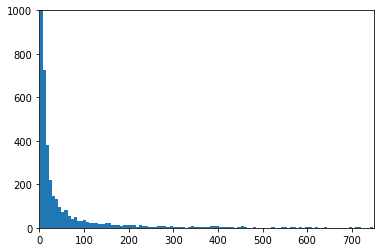

In [13]:
# Frequency of ICDs
icd_freq = Counter(icd_df.icd9_code)

pl.hist(icd_freq.values(), bins=2000)
pl.axis([0, 750, 0, 1000])

In [14]:
features = {}
for hadm_id,rows in tqdm.tqdm(icd_df.groupby('hadm_id')):
    feats = {}
    
    # ICD features
    for icd in rows.icd9_code:
        if icd_freq[icd] > 5:
            feats[icd] = 1
            
    # demographic features
    drows = demographics[demographics.hadm_id==hadm_id]
    if len(drows):
        feats[    f'race={drows.race.values[0]}'] = 1
        feats[f'gender={drows.gender.values[0]}'] = 1
        pass
    
    crows = cohort[cohort.hadm_id==hadm_id]
    feats['age'] = (crows.admittime.values[0] - crows.dob.values[0]) / (np.timedelta64(1, 'D') * 365.25)
    
    features[hadm_id] = feats
    
print(len(features))

100%|██████████| 39779/39779 [00:47<00:00, 832.19it/s]

39779


# ML Model

In [16]:
ids = list(set(features.keys()) & set(labels.keys()))
random.shuffle(ids)

ind = int(0.7 * len(ids))
train_ids = ids[:ind]
test_ids  = ids[ ind:]

print(len(train_ids), len(test_ids))

27845 11934


In [17]:
train_features = [features[hadmid] for hadmid in train_ids]
test_features  = [features[hadmid] for hadmid in  test_ids]

train_labels = [labels[hadmid] for hadmid in train_ids]
test_labels  = [labels[hadmid] for hadmid in  test_ids]

In [18]:
vect = DictVectorizer()
vect.fit(train_features)

DictVectorizer()

In [19]:
train_X = vect.transform(train_features)
test_X  = vect.transform( test_features)

print(train_X.shape)
print(test_X.shape)

(27845, 3026)
(11934, 3026)


In [20]:
xgb = xgboost.XGBClassifier(eval_metric='logloss')
xgb.fit(train_X, train_labels)

/afs/csail.mit.edu/u/w/wboag/.conda/envs/wb/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=32,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Evaluation

In [21]:
def evaluate_performance(labels, preds, thr=None):
    #print('AAA:', len(labels), len(preds))
    
    if not thr:
        n = int(0.9*len(preds))
        thr = sorted(preds)[n]
        
    preds_thr = [int(p>=thr) for p in preds]
    
    # confusion matrix
    tp,fp,fn,tn = 0,0,0,0
    for ref,pred in zip(labels,preds_thr):
        if   ref==0 and pred==0: tn += 1
        elif ref==0 and pred==1: fp += 1
        elif ref==1 and pred==0: fn += 1
        elif ref==1 and pred==1: tp += 1
    conf = {'TP':tp, 'FP':fp, 'FN':fn, 'TN':tn}
    recall    = float(tp) / (tp+fn+1e-9)
    precision = float(tp) / (tp+fp+1e-9)
    #print(conf)
    #print(recall)
    
    # AUC
    #print(labels)
    #print(preds)
    auc = roc_auc_score(labels, preds)
            
    results = {'recall':recall, 'precision':precision, 'auc':auc, 'conf':conf}
    return results

In [22]:
test_pred = xgb.predict_proba(test_X)[:,1]

print(test_pred.shape)

(11934,)


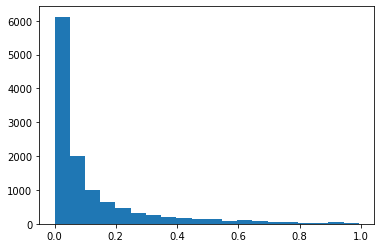

In [23]:
pl.hist(test_pred, bins=20)
pl.show()

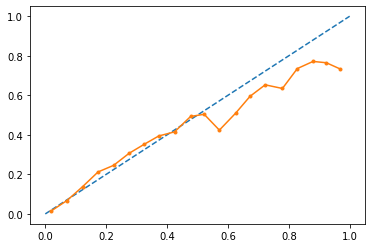

In [24]:
# reliability diagram
fop, mpv = calibration_curve(test_labels, test_pred, n_bins=20)
# plot perfectly calibrated
pl.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pl.plot(mpv, fop, marker='.')
pl.show()

In [25]:
# Overall AUC
roc_auc_score(test_labels, test_pred)

0.8742695138827192

White           (n=8215) R=450/1006(0.447)   P=450/ 902(0.499)   AUC=0.867


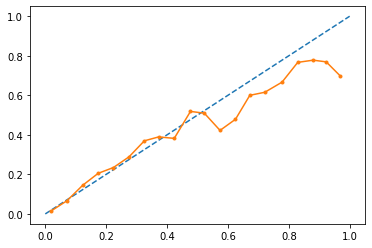

Not Specified   (n= 978) R= 41/ 130(0.315)   P= 41/  85(0.482)   AUC=0.853


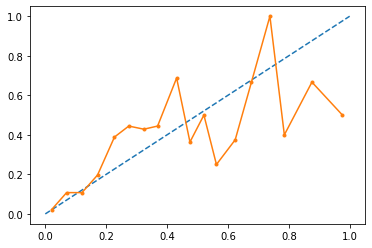

Black           (n=1010) R= 50/ 110(0.455)   P= 50/  92(0.543)   AUC=0.874


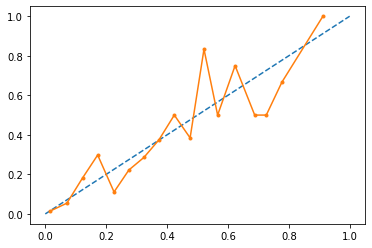

Other           (n= 685) R= 19/  50(0.380)   P= 19/  42(0.452)   AUC=0.901


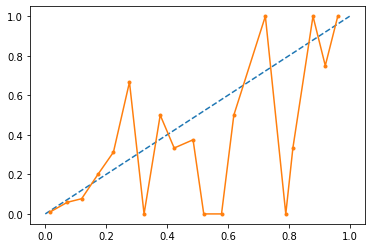

Hispanic        (n= 453) R=  9/  21(0.429)   P=  9/  22(0.409)   AUC=0.939


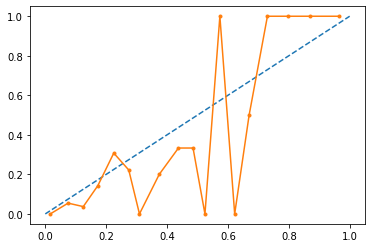

Asian           (n= 459) R= 20/  33(0.606)   P= 20/  35(0.571)   AUC=0.947


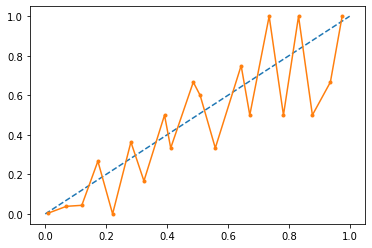

In [26]:
# Per race recall @ top-10%
n = int(0.9*len(test_pred))
thr = sorted(test_pred)[n]

test_demographics = demographics[demographics.hadm_id.isin(test_ids)]
for race in ['White', 'Not Specified', 'Black', 'Other', 'Hispanic', 'Asian']:
    #print(race)
    #display(rows)
    rows = test_demographics[test_demographics.race==race]
    group_ids = list(set(rows.hadm_id))
    group_features = [features[pid] for pid in group_ids]
    group_X = vect.transform(group_features)
    group_labels   = [labels[pid]   for pid in group_ids]
    group_pred = xgb.predict_proba(group_X) [:,1]
    
    results = evaluate_performance(group_labels, group_pred, thr=thr)
    conf = results['conf']
    tp,fp,fn,tn = conf['TP'], conf['FP'], conf['FN'], conf['TN']
    auc       = results['auc']
    precision = results['precision']
    recall    = results['recall']
    
    print(f'{race:15} (n={len(group_ids):4}) R={tp:3d}/{tp+fn:4}({recall:.3f})   P={tp:3d}/{tp+fp:4}({precision:.3f})   AUC={auc:.3f}')

    # reliability diagram
    fop, mpv = calibration_curve(group_labels, group_pred, n_bins=20)
    # plot perfectly calibrated
    pl.plot([0, 1], [0, 1], linestyle='--')
    # plot model reliability
    pl.plot(mpv, fop, marker='.')
    pl.show()
    
    #break

In [27]:
# Most informative features
svm = LinearSVC()
svm.fit(train_X, train_labels)

# map the dimensions to names
ind2feat =  { i:f for f,i in vect.vocabulary_.items() }

# create a 2-by-m matrix for biary, rather than relying on 1-p bullshit
coef_ = svm.coef_[0,:]

# most informative features
informative_feats = np.argsort(coef_)

#'''
# display what each feature is
for dim in list(reversed(informative_feats))[:25]:
    val = coef_[dim]

    word = ind2feat[dim]
    desc = icd_lookup[word]
    print(f'[{word[:3]+"."+word[3:]:6s}] [{desc[:50]:52}]: {val}')
    
print('\n')

for dim in list(reversed(informative_feats))[-25:]:
    val = coef_[dim]

    word = ind2feat[dim]
    desc = icd_lookup[word]
    print(f'[{word[:3]+"."+word[3:]:6s}] [{desc[:50]:52}]: {val}')

[157.8 ] [Malignant neoplasm of other specified sites of pan  ]: 1.0107442856991264
[191.2 ] [Malignant neoplasm of temporal lobe                 ]: 0.8838395639912784
[155.1 ] [Malignant neoplasm of intrahepatic bile ducts       ]: 0.8428394995942319
[191.9 ] [Malignant neoplasm of brain, unspecified            ]: 0.7885061453822193
[191.3 ] [Malignant neoplasm of parietal lobe                 ]: 0.7856818795122197
[996.75] [Other complications due to nervous system device,   ]: 0.7437462162267412
[191.4 ] [Malignant neoplasm of occipital lobe                ]: 0.7388599278705239
[156.1 ] [Malignant neoplasm of extrahepatic bile ducts       ]: 0.7160517063008455
[191.1 ] [Malignant neoplasm of frontal lobe                  ]: 0.705150617689962
[730.25] [Unspecified osteomyelitis, pelvic region and thigh  ]: 0.680661007721309
[996.85] [Complications of transplanted bone marrow           ]: 0.6764544479744641
[289.82] [Secondary hypercoagulable state                     ]: 0.65500408832

/afs/csail.mit.edu/u/w/wboag/.conda/envs/wb/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [28]:
for dim in list(reversed(informative_feats))[:25]:
    word = ind2feat[dim]
    desc = icd_lookup[word]
    
    # Look at prevalance in W vs B population
    pt_nums = train_X[:,dim].nonzero()[0]
    hadm_ids = [train_ids[ptnum] for ptnum in pt_nums]
    group_labels = [labels[hadm_id] for hadm_id in hadm_ids]
    frac_mort = float(sum(group_labels)) / len(group_labels)
    group_demographics = demographics[demographics.hadm_id.isin(hadm_ids)]

    print(f'[{word[:3]+"."+word[3:]:6s}] [{desc[:50]:52}] mort={sum(group_labels):2}/{len(group_labels):2} ({frac_mort:.3})')
    for race,rows in group_demographics.groupby('race'):
        print(f'\t{race:15}: n={len(rows)}')
    #display(group_demographics)
    
    #break

[157.8 ] [Malignant neoplasm of other specified sites of pan  ] mort=20/27 (0.741)
	Asian          : n=1
	Black          : n=1
	Not Specified  : n=1
	Other          : n=1
	White          : n=23
[191.2 ] [Malignant neoplasm of temporal lobe                 ] mort=14/26 (0.538)
	Black          : n=1
	Not Specified  : n=1
	Other          : n=2
	White          : n=16
[155.1 ] [Malignant neoplasm of intrahepatic bile ducts       ] mort=17/26 (0.654)
	Asian          : n=4
	Hispanic       : n=1
	Other          : n=2
	White          : n=19
[191.9 ] [Malignant neoplasm of brain, unspecified            ] mort=10/19 (0.526)
	Asian          : n=2
	Black          : n=1
	Not Specified  : n=2
	Other          : n=2
	White          : n=9
[191.3 ] [Malignant neoplasm of parietal lobe                 ] mort= 7/18 (0.389)
	Hispanic       : n=1
	Other          : n=1
	White          : n=14
[996.75] [Other complications due to nervous system device,   ] mort= 3/ 7 (0.429)
	Other          : n=1
	White        

In [29]:
for dim in list(reversed(informative_feats))[-25:]:
    word = ind2feat[dim]
    desc = icd_lookup[word]
    
    # Look at prevalance in W vs B population
    pt_nums = train_X[:,dim].nonzero()[0]
    hadm_ids = [train_ids[ptnum] for ptnum in pt_nums]
    group_labels = [labels[hadm_id] for hadm_id in hadm_ids]
    frac_mort = float(sum(group_labels)) / len(group_labels)
    group_demographics = demographics[demographics.hadm_id.isin(hadm_ids)]

    print(f'[{word[:3]+"."+word[3:]:6s}] [{desc[:50]:52}] mort={sum(group_labels):2}/{len(group_labels):2} ({frac_mort:.3})')
    for race,rows in group_demographics.groupby('race'):
        print(f'\t{race:15}: n={len(rows)}')
    #display(group_demographics)
    
    #break

[233.0 ] [Carcinoma in situ of breast                         ] mort= 0/10 (0.0)
	Black          : n=4
	Not Specified  : n=1
	Other          : n=2
	White          : n=2
[574.31] [Calculus of bile duct with acute cholecystitis, wi  ] mort= 0/12 (0.0)
	Black          : n=1
	Not Specified  : n=3
	White          : n=7
[756.79] [Other congenital anomalies of abdominal wall        ] mort= 0/14 (0.0)
	Asian          : n=1
	Black          : n=1
	Not Specified  : n=1
	White          : n=11
[130.7 ] [Toxoplasmosis of other specified sites              ] mort= 0/ 6 (0.0)
	Black          : n=2
	Hispanic       : n=1
	White          : n=3
[580.89] [Acute glomerulonephritis with other specified path  ] mort= 1/22 (0.0455)
	Black          : n=2
	Other          : n=3
	White          : n=17
[789.2 ] [Splenomegaly                                        ] mort= 1/31 (0.0323)
	Asian          : n=1
	Black          : n=1
	Hispanic       : n=1
	Other          : n=3
	White          : n=24
[571.49] [Other chron

In [30]:
# Run multiple times
aucs    = {'Black':[], 'White':[]}
recalls = {'Black':[], 'White':[]}
for i in tqdm.tqdm(range(20)):
    # Randomly split data
    ids = list(set(features.keys()) & set(labels.keys()))
    random.shuffle(ids)
    ind = int(0.7 * len(ids))
    train_ids = ids[:ind]
    test_ids  = ids[ ind:]

    # train/test separation
    train_features = [features[hadmid] for hadmid in train_ids]
    test_features  = [features[hadmid] for hadmid in  test_ids]

    train_labels = [labels[hadmid] for hadmid in train_ids]
    test_labels  = [labels[hadmid] for hadmid in  test_ids]
    
    # vectorizer
    vect = DictVectorizer()
    vect.fit(train_features)
    train_X = vect.transform(train_features)
    test_X  = vect.transform( test_features)
    
    # fit model
    xgb = xgboost.XGBClassifier(eval_metric='logloss', use_label_encoder=False)
    xgb.fit(train_X, train_labels)
    
    # threshold across groups
    test_pred = xgb.predict_proba(test_X) [:,1]
    n = int(0.9*len(test_pred))
    thr = sorted(test_pred)[n]
    
    # predict and eval for black vs white
    test_demographics = demographics[demographics.hadm_id.isin(test_ids)]
    for race in ['White', 'Black']:
        rows = test_demographics[test_demographics.race==race]
        group_ids = list(set(rows.hadm_id))
        group_features = [features[pid] for pid in group_ids]
        group_X = vect.transform(group_features)
        group_labels   = [labels[pid]   for pid in group_ids]
        group_pred = xgb.predict_proba(group_X) [:,1]

        results = evaluate_performance(group_labels, group_pred, thr=thr)
        aucs[race].append(results['auc'])
        recalls[race].append(results['recall'])
        
    
    #break
    
#print(aucs)
#print()
print('AUC')
for race in ['White', 'Black']:
    print(f'{race}: {np.mean(aucs[race])} +/- {np.std(aucs[race])}')
    for auc in aucs[race]:
        print(f'\t{auc}')
    print()
    
print('Recall')
for race in ['White', 'Black']:
    print(f'{race}: {np.mean(recalls[race])} +/- {np.std(recalls[race])}')
    for r in recalls[race]:
        print(f'\t{r}')
    print()

100%|██████████| 20/20 [00:35<00:00,  1.76s/it]

AUC
White: 0.871189224414344 +/- 0.004016378176617424
	0.866763589596628
	0.875214592624203
	0.8764867882750761
	0.8769313236202977
	0.8698720966359111
	0.8741486977508469
	0.8672139249621631
	0.8684714250004565
	0.875702845401412
	0.872304019562298
	0.8760072410344195
	0.8704742958323242
	0.8704471244046761
	0.8674759340280942
	0.8697065612767747
	0.8634037704751677
	0.8759884898701946
	0.8654553362545165
	0.8734560111114433
	0.8682604205699777

Black: 0.8744385074547404 +/- 0.01582127909642227
	0.8819221387688071
	0.8312719547338088
	0.8769229122284907
	0.8811996634210842
	0.8973108553350289
	0.898390022675737
	0.8776606218126686
	0.8504210988276109
	0.8793060883436515
	0.8476064997804127
	0.8654536871703302
	0.8915245943571437
	0.8870446533490012
	0.8713635393697988
	0.8749701314217444
	0.8719919267194536
	0.8746907015106791
	0.8771303258145363
	0.8715073718940097
	0.8810813615608136

Recall
White: 0.4444237812815718 +/- 0.010343622797939857
	0.44985394352439156
	0.45348837209258386

In [31]:
# Aversge risk score per race

# Per race recall @ top-10%
n = int(0.9*len(test_pred))
thr = sorted(test_pred)[n]

test_demographics = demographics[demographics.hadm_id.isin(test_ids)]
scores = {}
for race in ['White', 'Black']:
    #print(race)
    #display(rows)
    rows = test_demographics[test_demographics.race==race]
    group_ids = list(set(rows.hadm_id))
    group_features = [features[pid] for pid in group_ids]
    group_X = vect.transform(group_features)
    group_labels   = [labels[pid]   for pid in group_ids]
    group_pred = xgb.predict_proba(group_X) [:,1]
    scores[race] = group_pred

		white: 8209 0.054121442
		black: 986 0.04027945
		p-value: 1.0285042146118451e-12


<ipython-input-32-aa7ab65543c0>:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = pl.subplot(111)


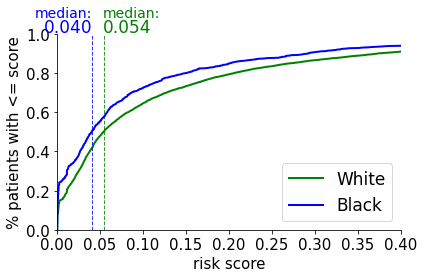

In [32]:
def list_median(vals):
    svals = sorted(vals)
    return svals[int(len(svals)/2)]


def plot_distributions(dists):
    fig = pl.figure()

    p1 = list(dists['White'])
    p2 = list(dists['Black'])
    
    white_median = list_median(p1)
    black_median = list_median(p2)
    smaller_median = min(white_median, black_median)

    #colors = ['#00A6ED', '#FF5400']
    colors = ['green', 'blue']
    for i,race in enumerate(['White', 'Black']):
        vals = list(dists[race])
        pl.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[i], label=race, lw=2)
        pl.xlim((0,0.4))
        pl.ylim((0,1.0))

        median = list_median(vals)
        pl.axvline(x=median, linestyle="--", lw=1, color=colors[i], alpha=0.8) 
        if median == smaller_median:
            p = .001
            h = 'right'
        else:
            p = -.001
            h = 'left'
        #h = 'center'
        pl.text(x=median+p, y=1.085, horizontalalignment=h, s="median:"      , fontsize=14, color=colors[i])
        pl.text(x=median+p, y=1.01 , horizontalalignment=h, s=f'{median:.3f}', fontsize=17, color=colors[i])


    ax = pl.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    pl.yticks(fontsize=15)    
    pl.xticks(fontsize=15) 

    pl.legend(loc=4, fontsize=17)
    pl.ylabel("% patients with <= score", fontsize=15)
    pl.xlabel('risk score', fontsize=15)

    pl.tight_layout()

    w = mannwhitneyu(p1, p2)
    print('\t\twhite:', len(p1), white_median)
    print('\t\tblack:', len(p2), black_median)
    print('\t\tp-value:', w.pvalue)
    pl.show()
    

    
plot_distributions(scores)

In [33]:
# TODO: could build model to distinguish black vs white (to see what top separators are)
pass